In [32]:
import csv
import os
import pymc as pm
from pymc import do, observe
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.stats as stats
import seaborn as sns
import itertools as it
import country_converter as cc
import math
from sklearn.linear_model import LinearRegression
import graphviz
import random

# Load data

In [8]:
data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset.csv")
missing_indices = []
no_nan_cols = ["UDel_temp_popweight","UDel_precip_popweight","growthWDI"]
for index, row in enumerate(data.itertuples()):
    if any(np.isnan(getattr(row,col)) for col in no_nan_cols):
        missing_indices.append(index)
data = data.drop(missing_indices).reset_index(drop=True)
test_data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset_test.csv")
train_data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset_train.csv")
grad_effect_columns = train_data.loc[:, train_data.columns.str.startswith(('_y'))]
ordered_country_list = list(dict.fromkeys(train_data.iso))
enc = OrdinalEncoder()
enc.fit(np.array(ordered_country_list).reshape(-1,1))
data["encoded_iso_id"] = [int(val) for val in enc.transform(np.array(data.iso_id).reshape(-1,1))]
data["block"] = [row.continent + "_" + str(row.year) for row in data.itertuples()]

/tmp/ipykernel_107065/436208037.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data["encoded_iso_id"] = [int(val) for val in enc.transform(np.array(data.iso_id).reshape(-1,1))]


In [ ]:
# Add third degree incremental effects
for column in data:
    if "_yi" in column:
        new_column = column.replace("_yi", "_y3")
        data[new_column] = [getattr(row[1],column)**3 for row in data.iterrows()]

# Make dataset withholding random data points

In [ ]:
random.seed(1)
indices_to_drop = []
all_years = set(data.year)
for year in all_years:
    year_rows = data.loc[data.year == year]
    year_row_indices = list(year_rows.index)
    drop_from_this_year = random.sample(year_row_indices, 6)
    for index in drop_from_this_year:
        indices_to_drop.append(index)
withheld_rows = data.iloc[indices_to_drop]
data_len_before = len(data)
data_mod = data.drop(indices_to_drop)
data_mod = data_mod.reset_index(drop=True)
print(f"Removed {data_len_before - len(data_mod)} rows.")

In [ ]:
data_mod.to_csv("../data/burke/data/input/GrowthClimateDataset_train_3rd_degree_grad_effects.csv")

In [ ]:
data_mod.to_csv("../data/burke/data/input/GrowthClimateDataset_train_3rd_degree_grad_effects.csv")

In [ ]:
pd.DataFrame(withheld_rows).to_csv("../data/burke/data/input/GrowthClimateDataset_test_3rd_degree_grad_effects.csv")

In [ ]:
data.to_csv("../data/burke/data/input/GrowthClimateDataset_full_encoded_iso_id_block_id_3rd_degree_grad_effects.csv")

In [ ]:
# Add back missing data
data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset.csv")
missing_rows = data.iloc[missing_indices]
data_mod_with_missing = data_mod._append(missing_rows, ignore_index=True)
pd.DataFrame(data_mod_with_missing).to_csv("../data/burke/data/input/GrowthClimateDataset_train_missing_data.csv")

# Bayesian Model

In [3]:
model = pd.read_pickle('../models/nature_reproduction/burke-reproduction-mcmc-fixed-effects-grad-effects-deterministic-observed-hierarchical-std-error.pkl')
trace = model["trace"]
prior = model["prior"]
posterior = model["posterior"]
precip_scaler = model["precip_scaler"]
gdp_scaler = model["gdp_scaler"]
temp_scaler = model["temp_scaler"]

In [6]:
az.summary(trace, var_names=["temp_gdp_coef","temp_sq_gdp_coef","precip_gdp_coef","precip_sq_gdp_coef","gdp_intercept"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
temp_gdp_coef,-0.640,0.221,-1.061,-0.225,0.016,0.011,191.0,491.0,1.02
temp_sq_gdp_coef,-0.454,0.090,-0.623,-0.284,0.004,0.003,606.0,1520.0,1.01
precip_gdp_coef,0.053,0.063,-0.066,0.172,0.002,0.001,1501.0,2235.0,1.00
precip_sq_gdp_coef,-0.042,0.022,-0.083,-0.001,0.000,0.000,1931.0,2377.0,1.00
gdp_intercept,0.386,0.423,-0.412,1.210,0.050,0.038,71.0,128.0,1.06


/tmp/ipykernel_5773/3226979871.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


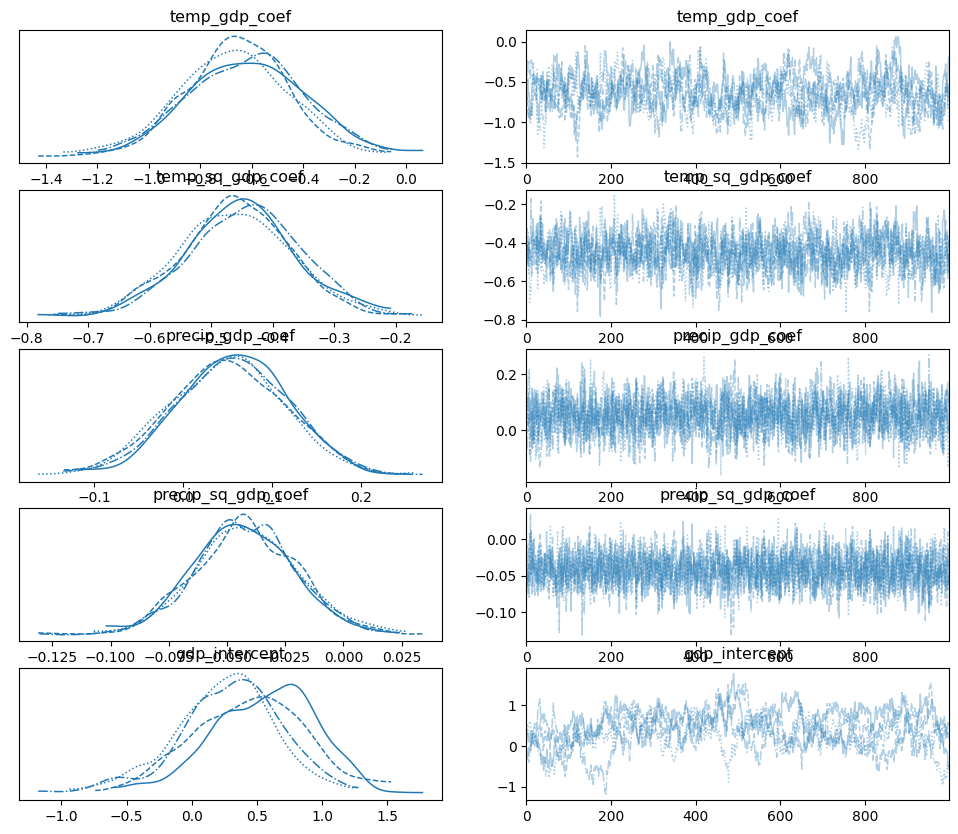

In [44]:
fig = az.plot_trace(trace, var_names=["temp_gdp_coef","temp_sq_gdp_coef","precip_gdp_coef","precip_sq_gdp_coef", "gdp_intercept"]).ravel()[0].figure
fig.show()

# Bayesian Model Vertex Confidence Bounds

In [4]:
random.seed(1)
indices = random.sample(range(4000),1000)
coef1 = trace.posterior.temp_gdp_coef.data.flatten()
coef2 = trace.posterior.temp_sq_gdp_coef.data.flatten()
coef1 = (coef1 * np.std(data.growthWDI) / np.std(data.UDel_temp_popweight)) - (2 * (coef2 * np.mean(data.UDel_temp_popweight * np.std(data.growthWDI)) / np.square(np.std(data.UDel_temp_popweight))))
coef2 = (coef2 * np.std(data.growthWDI) / np.square(np.std(data.UDel_temp_popweight)))
coef1 = [sample for index, sample in enumerate(coef1) if index in indices]
coef2 = [sample for index, sample in enumerate(coef2) if index in indices]
numerator = [val for val in coef1]
denominator = [-2*(val) for val in coef2]
bayes_res = np.array(numerator) / np.array(denominator)
bayes_interval = np.quantile(sorted(bayes_res),[.05,.95])
print(np.mean(bayes_res), bayes_interval[0], bayes_interval[1])

13.667917470588941 10.941736577560095 16.305551240529617


# Bayesian Model Prediction Intervals

In [9]:
bayes_coef1 = trace.posterior.temp_gdp_coef.data.flatten()
bayes_coef2 = trace.posterior.temp_sq_gdp_coef.data.flatten()
bayes_coef3 = trace.posterior.precip_gdp_coef.data.flatten()
bayes_coef4 = trace.posterior.precip_sq_gdp_coef.data.flatten()
intercept = trace.posterior.gdp_intercept.data.flatten()
grad_coefs = np.transpose(np.vstack(trace.posterior.grad_effect_coefs.data))
country_coefs = np.transpose(np.vstack(trace.posterior.country_coefs.data))
year_coefs = np.transpose(np.vstack(trace.posterior.year_coefs.data))

In [10]:
# unscale all model parameters

bayes_coef1 = (bayes_coef1 * np.std(train_data.growthWDI) / np.std(train_data.UDel_temp_popweight)) - (2 * (bayes_coef2 * np.mean(train_data.UDel_temp_popweight * np.std(train_data.growthWDI)) / np.square(np.std(train_data.UDel_temp_popweight))))
bayes_coef2 = (bayes_coef2 * np.std(train_data.growthWDI) / np.square(np.std(train_data.UDel_temp_popweight)))
bayes_coef3 = (bayes_coef3 * np.std(train_data.growthWDI) / np.std(train_data.UDel_precip_popweight)) - (2 * (bayes_coef4 * np.mean(train_data.UDel_precip_popweight * np.std(train_data.growthWDI)) / np.square(np.std(train_data.UDel_precip_popweight))))
bayes_coef4 = (bayes_coef4 * np.std(train_data.growthWDI)) / np.square(np.std(train_data.UDel_precip_popweight))

intercept = (intercept * np.std(train_data.growthWDI)) + np.mean(train_data.growthWDI) - ((bayes_coef1 * np.mean(train_data.UDel_temp_popweight)) + (bayes_coef2 * np.square(np.mean(train_data.UDel_temp_popweight))) + (bayes_coef3 * np.mean(train_data.UDel_precip_popweight)) + (bayes_coef4 * np.square(np.mean(train_data.UDel_precip_popweight))))
for i in range(len(grad_coefs)):
    grad_coefs[i] = (grad_coefs[i] * np.std(train_data.growthWDI))
for i in range(len(country_coefs)):
    country_coefs[i] = country_coefs[i] * np.std(train_data.growthWDI)
for i in range(len(year_coefs)):
    year_coefs[i] = year_coefs[i] * np.std(train_data.growthWDI)

In [11]:
bayes_yhat = []
bayes_real_y = []
min_year = min(train_data.year)
grad_effect_column_names = list(grad_effect_columns)
for row in test_data.sort_values(by="growthWDI").iterrows():
# for row in train_data.iterrows():
    temp = row[1].UDel_temp_popweight
    precip = row[1].UDel_precip_popweight
    country = row[1].iso
    year = row[1].year
    bayes_real_y.append(row[1].growthWDI)
    if country == ordered_country_list[0]:
        country_effect = 0
    else:
        country_effect = country_coefs[ordered_country_list.index(country)-1]
    if year - min_year == 0:
        year_effect = 0
    else:
        year_effect = year_coefs[year - min_year -1]
    predict_gdp = (
        temp*bayes_coef1 + 
        np.square(temp)*bayes_coef2 +
        precip*bayes_coef3 +
        np.square(precip)*bayes_coef4 +
        country_effect +
        year_effect +
        intercept
    )
    grad_effect = 0
    for i, effect in enumerate(grad_effect_column_names):
        grad_effect += row[1][effect]* grad_coefs[i]
    predict_gdp += grad_effect
    bayes_yhat.append(sorted(predict_gdp))

In [73]:
in_range, out_range = 0, 0
bayes_lowers, bayes_uppers = [], []
for index, prediction in enumerate(bayes_yhat):
    interval = np.quantile(prediction,[.025,.975])
    bayes_lowers.append(interval[0])
    bayes_uppers.append(interval[1])
    if bayes_real_y[index] >= interval[0] and bayes_real_y[index] <= interval[1]:
        in_range += 1
    else:
        out_range += 1
print(in_range/len(bayes_yhat))
print(out_range/len(bayes_yhat))

pred_int_distances = []
for i in range(len(bayes_lowers)):
    pred_int_distances.append(bayes_uppers[i]-bayes_lowers[i])
print(np.mean(sorted(pred_int_distances[100:200])))
print(np.std(sorted(pred_int_distances[100:200])))

0.6166666666666667
0.38333333333333336
0.057126502365158996
0.014180156992327702


# Block Bootstrap

In [ ]:
bootstrap_reps = pd.read_csv("../data/burke/data/input/bootstrap/burke_stata_bootstrap_block.csv")
column_names = list(bootstrap_reps.iloc[0])
for index, column in enumerate(column_names):
    if "year" in column:
        column_names[index] = column.split("[")[1].split(".")[0].replace("b","")
    elif "isoxtim" in column:
        column_names[index] = column.split("[")[1].split("]")[0].replace("o.","")
    elif "encoded_iso_id" in column:
        column_names[index] = ordered_country_list[int(column.split("[")[1].split(".")[0].replace("b",""))]
    elif "_b" in column:
        if "cons" in column:
            column_names[index] = "intercept"
        else:
            column_names[index] = column.replace("_b[","").replace("]","")
bootstrap_reps.iloc[0] = column_names
bootstrap_reps.to_csv("../data/burke/data/input/bootstrap/burke_stata_bootstrap_replications_block_better_column_names.csv")

In [14]:
bootstrap_reps = pd.read_csv("../data/burke/data/input/bootstrap/burke_stata_bootstrap_replications_block_better_column_names.csv", header=1)[:1000]

# Block Bootstrap Vertex Confidence Bounds

In [15]:
numerator = [val for val in bootstrap_reps["temp"] if not np.isnan(val)]
denominator = [-2*(val) for val in bootstrap_reps["c.temp#c.temp"] if not np.isnan(val)]
boot_res = np.array(numerator) / np.array(denominator)
boot_interval = np.quantile(boot_res,[.05,.95])
print(np.mean(boot_res), boot_interval[0], boot_interval[1])

13.35981574323662 10.17496944932989 17.224900438584346


# Block Bootstrap Prediction Intervals

In [67]:
bootstrap_reps = pd.read_csv("../data/burke/data/input/bootstrap/burke_stata_bootstrap_replications_block_withheld_better_column_names.csv", header=1)
# bootstrap_reps = pd.read_csv("../data/burke/data/input/bootstrap/burke_stata_bootstrap_replications_better_column_names.csv", header=1)

indices_to_drop = []
no_nan_cols = ["temp"]
for index, row in enumerate(bootstrap_reps.itertuples()):
    if any(np.isnan(getattr(row,col)) for col in no_nan_cols):
        indices_to_drop.append(index)
bootstrap_reps = bootstrap_reps.drop(indices_to_drop)[:1000]

boot_yhat = []
boot_real_y = []
min_year = min(train_data.year)
grad_effect_column_names = list(grad_effect_columns)
for row in test_data.sort_values(by="growthWDI").iterrows():
# for row in train_data.iterrows():
    temp = row[1].UDel_temp_popweight
    precip = row[1].UDel_precip_popweight
    country = row[1].iso
    year = row[1].year
    boot_real_y.append(row[1].growthWDI)
    predict_gdp = (
        temp*bootstrap_reps.temp + 
        np.square(temp)*bootstrap_reps["c.temp#c.temp"] +
        precip*bootstrap_reps.udel_precip_popweight +
        np.square(precip)*bootstrap_reps.udel_precip_popweight_2 +
        bootstrap_reps[country] +
        bootstrap_reps[str(year)] +
        bootstrap_reps["intercept"]
    )
    grad_effect = 0
    for i, effect in enumerate(grad_effect_column_names):
        grad_effect += row[1][effect]* bootstrap_reps[effect.lower()]
    predict_gdp += grad_effect
    boot_yhat.append(sorted(predict_gdp))

In [72]:
in_range, out_range = 0, 0
boot_lowers, boot_uppers = [], []
for index, prediction in enumerate(boot_yhat):
    interval = np.quantile(prediction,[.025,.975])
    boot_lowers.append(interval[0])
    boot_uppers.append(interval[1])
    if boot_real_y[index] >= interval[0] and boot_real_y[index] <= interval[1]:
        in_range += 1
    else:
        out_range += 1
print(in_range/len(boot_yhat))
print(out_range/len(boot_yhat))

pred_int_distances = []
for i in range(len(boot_lowers)):
    pred_int_distances.append(boot_uppers[i]-boot_lowers[i])
print(np.mean(sorted(pred_int_distances[100:200])))
print(np.std(sorted(pred_int_distances[100:200])))

0.57
0.43
0.05622105788052347
0.029416448656794606


# Delta Method

In [18]:
# Simulation from Stata 
random.seed(1)
delta_vertex = 13.055431
delta_sd = 1.7304575
delta_sim_res = np.random.normal(delta_vertex, delta_sd, 1000)
delta_interval = np.quantile(delta_sim_res,[.05,.95])
print(np.mean(delta_sim_res), delta_interval[0], delta_interval[1])

13.09739291364208 10.203826629725882 15.966537189287681


In [70]:
in_range = 0
out_range = 0
delta_lowers, delta_uppers = [], []
delta_real_y = []

delta_yhat = pd.read_csv("../data/burke/data/input/burke_stdp_pred_outsample.csv")
# delta_yhat = pd.read_csv("../data/burke/data/input/burke_stdp_pred_insample.csv")
for row in enumerate(delta_yhat.sort_values(by="growthwdi").itertuples()):
    lower = row[1].lower
    upper = row[1].upper
    delta_real_y.append(row[1].growthwdi)
    if lower <= delta_real_y[-1] and upper >= delta_real_y[-1]:
        in_range += 1
    else:
        out_range += 1
    delta_lowers.append(lower), delta_uppers.append(upper)

print(in_range / len(delta_yhat))
print(out_range / len(delta_yhat))

pred_int_distances = []
for i in range(len(delta_lowers)):
    pred_int_distances.append(delta_uppers[i]-delta_lowers[i])
print(np.mean(sorted(pred_int_distances[100:200])))
print(np.std(sorted(pred_int_distances[100:200])))

0.6033333333333334
0.39666666666666667
0.062144925025600005
0.01915083750263514


# Make Figure 1

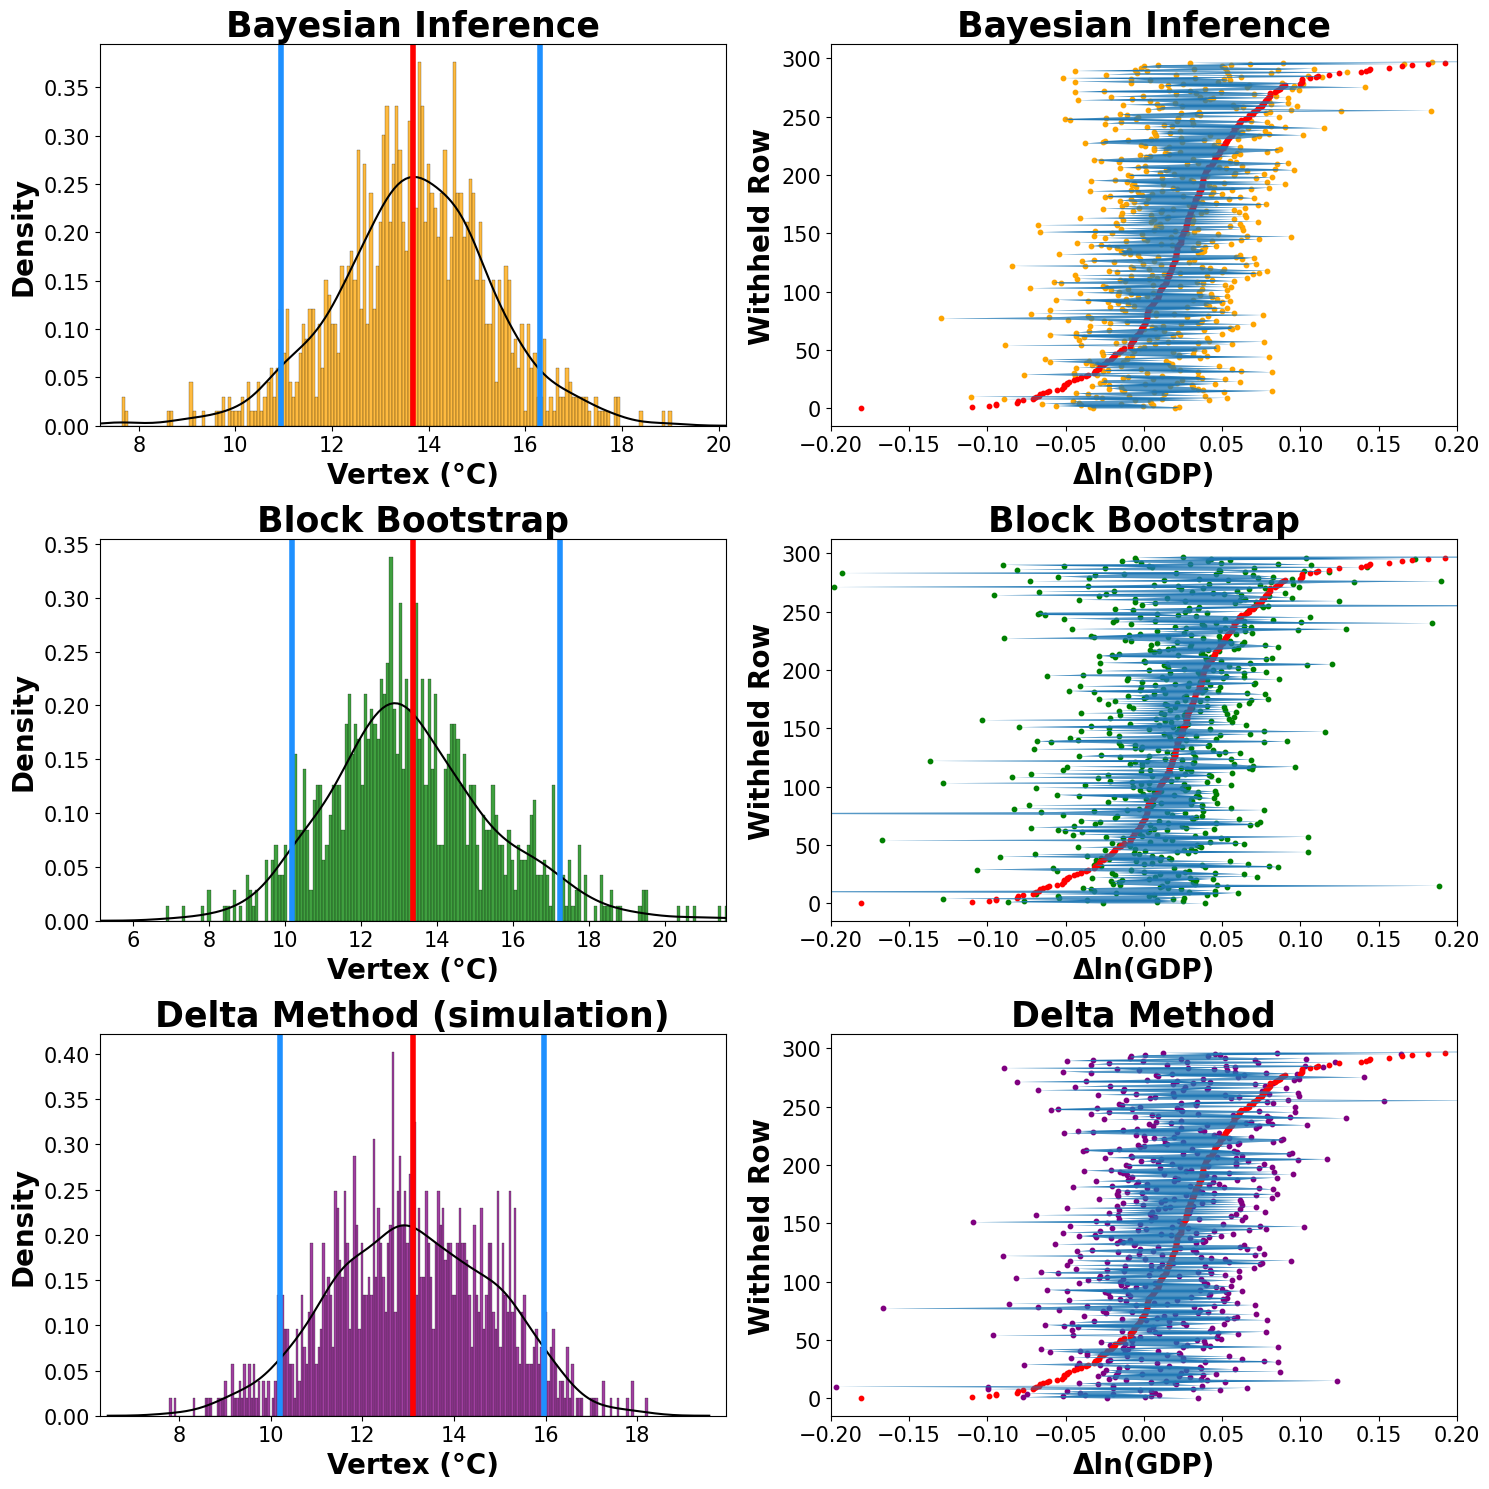

In [75]:
def make_hist_plot(axis, data, interval, color, labels):
    x = np.linspace(np.mean(data) - 3*np.std(data), np.mean(data) + 3*np.std(data), 100)
    sns.histplot(data,bins=200,color=color,stat="density", ax=axis)
    sns.kdeplot(data, ax=axis, color="black")
    axis.set_xlim(min(x)-1.5, max(x)+1.5)
    axis.xaxis.label.set_size(20)
    axis.yaxis.label.set_size(20)
    axis.xaxis.set_tick_params(labelsize=15)
    axis.yaxis.set_tick_params(labelsize=15)
    axis.axvline(x = np.mean(data), color = 'r', lw = 4, label = labels[0])
    axis.axvline(x = interval[0], color = 'dodgerblue', lw = 4, label = labels[1])
    axis.axvline(x = interval[1], color = 'dodgerblue', lw = 4, label = labels[2])
    # axis.axvline(x = delta_vertex, color = ('k' if mean_line else 'r'), lw = 4, label = labels[3])
    axis.set_xlabel("Vertex (°C)", weight="bold")
    axis.set_ylabel("Density", weight="bold")
    axis.set_title(labels[4], weight="bold")
    axis.title.set_size(25)
    # axis.legend(fontsize=12)

def make_pred_int_plots(axis, lowers, uppers, real_y, color, label):
    axis.scatter(lowers, list(range(len(lowers))), color=color, s=10)
    axis.scatter(uppers, list(range(len(lowers))), color=color, s=10)
    axis.scatter(real_y, list(range(len(lowers))), color="red", s=10)
    last_line = None
    for index in range(len(lowers)):
        if last_line != None:
            axis.add_patch(
                patches.Polygon(
                    xy=[[last_line[0],index-1],[last_line[1],index-1],[uppers[index],index],[lowers[index],index]]
                )
            )
        last_line = [lowers[index],uppers[index]]
    axis.set_xlabel("Δln(GDP)", weight="bold")
    axis.set_ylabel("Withheld Row", weight="bold")
    axis.xaxis.label.set_size(20)
    axis.yaxis.label.set_size(20)
    axis.xaxis.set_tick_params(labelsize=15)
    axis.yaxis.set_tick_params(labelsize=15)
    axis.set_title(label, weight="bold")
    axis.title.set_size(25)
    axis.set_xlim(-.2, .2)

fig, axes = plt.subplots(3,2, figsize=(15,15))

colors = {"Bayes":"orange","Bootstrap":"green","Delta":"purple"}

make_hist_plot(axes[0][0], bayes_res, bayes_interval, colors["Bayes"],
    labels=[
    'Bayesian Inference Vertex Mean', 'Bayesian Inference Vertex Lower Bound',
    'Bayesian Inference Vertex Upper Bound', 'Original Burke et al. Estimate',
    'Bayesian Inference'
])
make_hist_plot(axes[1][0], boot_res, boot_interval, colors["Bootstrap"],
    labels=[
    'Block Bootstrap Vertex Mean', 'Block Bootstrap Vertex Lower Bound',
    'Block Bootstrap Vertex Upper Bound', 'Original Burke et al. Estimate',
    'Block Bootstrap'
])
make_hist_plot(axes[2][0], delta_sim_res, delta_interval, colors["Delta"],
    labels=[
    'Delta Method Vertex Mean', 'Delta Method Vertex Lower Bound',
    'Delta Method Vertex Upper Bound', 'Original Burke et al. Estimate',
    'Delta Method (simulation)'
])

make_pred_int_plots(axes[0][1], bayes_lowers[2:300], bayes_uppers[2:300], bayes_real_y[2:300], colors["Bayes"], "Bayesian Inference")
make_pred_int_plots(axes[1][1], boot_lowers[2:300], boot_uppers[2:300], boot_real_y[2:300], colors["Bootstrap"], "Block Bootstrap")
make_pred_int_plots(axes[2][1], delta_lowers[2:300], delta_uppers[2:300], delta_real_y[2:300], colors["Delta"], "Delta Method")

fig.tight_layout()

# plt.show()
plt.savefig("../figures/fig1_working.png", bbox_inches='tight')

# Estimate affected countries based on CMIP6

In [50]:
temp_projections = pd.read_csv(
    "../data/global_data/cmip6-x0.25_timeseries_tas_timeseries-tas-annual-mean_annual_2015-2100_median_ssp119_ensemble_all_mean - all.csv"
)
mean_point_estimate = np.mean([np.mean(bayes_res),np.mean(boot_res),np.mean(delta_res)])
mean_lower_estimate = np.mean([bayes_interval[0],boot_interval[0],delta_interval[0]])
mean_upper_estimate = np.mean([bayes_interval[1],boot_interval[1],delta_interval[1]])
mean_countries = set()
range_countries = set()
count = 0
for row in temp_projections.iterrows():
    row = row[1]
    country = row.code
    if "." not in country:
        temp_2015 = row["2024-07"]
        temp_2100 = row["2100-07"]
        if temp_2015 < mean_point_estimate and temp_2100 > mean_point_estimate:
            mean_countries.add(country)
        if temp_2100 > mean_lower_estimate and temp_2100 < mean_upper_estimate:
            range_countries.add(country)
print(sorted(list(cc.convert(names = mean_countries, to = 'name_short'))))
print(sorted(list(cc.convert(names = range_countries, to = 'name_short'))))

KSV not found in ISO3


['Croatia', 'Japan', 'Nepal']
['Afghanistan', 'Albania', 'Argentina', 'Azerbaijan', 'Belgium', 'Bhutan', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'France', 'Germany', 'Greece', 'Guernsey', 'Hungary', 'Ireland', 'Isle of Man', 'Italy', 'Japan', 'Jersey', 'Lesotho', 'Moldova', 'Monaco', 'Montenegro', 'Nepal', 'Netherlands', 'New Zealand', 'North Macedonia', 'Romania', 'San Marino', 'Serbia', 'Slovenia', 'South Korea', 'Spain', 'Türkiye', 'United States', 'Uzbekistan', 'not found']


# Build map based on CMIP6 predictions